Loading datasets and Exploratory analysis/cleaning data

In [ ]:
## run only first cell and then load the data

In [ ]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
data1=pd.read_csv('drive/My Drive/Colab Notebooks/awardtravel_csvfile.csv',dtype=object)
pd.set_option("display.max_columns",101)
data2=pd.read_csv('drive/My Drive/Colab Notebooks/airlinessub_csvfile.csv',dtype=object)
data3=pd.read_csv('drive/My Drive/Colab Notebooks/airlinessub2_csvfile.csv',dtype=object)

Merge data2 and data3 from 'airlines' subreddit

In [ ]:
df2_3=pd.concat([data2,data3])
data4=pd.read_csv('drive/My Drive/Colab Notebooks/flights_csvfile.csv',dtype=object)
df_final=pd.concat([data1,df2_3,data4])

keeping relevant columns (keeping: 'subreddit_id','subreddit','body','created_utc','controversiality')

In [ ]:
df_final=df_final[['body','created_utc','controversiality']]
df_final.head(5)

,body,created_utc,controversiality
0,The April 2023 flights were booked in April-Ma...,1672642725,0
1,Wow thanks. Harsh reality check but that expla...,1672642538,0
2,If you are asking for help finding flights or ...,1672642243,0
3,"Transfer to Hyatt. Also, read the sidebar.",1672642039,0
4,"Lol, whelp hopefully your plans are flexible a...",1672641432,0


##CLEANING

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
##convert to lowercase to maintain uniformity

In [ ]:
df_final = df_final.assign(body=lambda df: df.body.str.lower())
df_final.head(5)

,body,created_utc,controversiality
0,the april 2023 flights were booked in april-ma...,1672642725,0
1,wow thanks. harsh reality check but that expla...,1672642538,0
2,if you are asking for help finding flights or ...,1672642243,0
3,"transfer to hyatt. also, read the sidebar.",1672642039,0
4,"lol, whelp hopefully your plans are flexible a...",1672641432,0


In [ ]:
df_final['body']=df_final['body'].astype(str) #convert body col to string

In [ ]:
df_final['body'] = df_final['body'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)) #Remove special characters and numbers using regular expressions.

In [ ]:
df_final.dtypes

,0
body,object
created_utc,object
controversiality,object


In [ ]:
df_final.isna().sum() #check for NA

,0
body,0
created_utc,4278
controversiality,4278


In [ ]:
##tokenization
##word_tokens = nltk.word_tokenize(tt)

In [ ]:
df_final['tokens'] = df_final.apply(lambda x: nltk.word_tokenize(x['body']) if isinstance(x['body'], str) else [], axis=1)
df_final['tokens'].head()

,tokens
0,"[the, april, flights, were, booked, in, aprilm..."
1,"[wow, thanks, harsh, reality, check, but, that..."
2,"[if, you, are, asking, for, help, finding, fli..."
3,"[transfer, to, hyatt, also, read, the, sidebar]"
4,"[lol, whelp, hopefully, your, plans, are, flex..."


In [ ]:
## stop word removal

In [ ]:

nltk.download('stopwords')
stopword = stopwords.words('english')
stopword.append(',')
stopword.append('.')
stopword.append('?')
stopword.append(':')
stopword.append('!')
stopword.append(';')
stopword.append('_')
stopword.append('-')
stopword.append('()')
stopword.append('(')
stopword.append(')')
stopword.append("n't")
stopword.append("'s")
stopword.append("'")
stopword.append("*")
stopword.append("[]")
stopword.append("[")
stopword.append("]")
stopword.append("$")
stopword.append("&")
stopword.append("`")
stopword.append("^")
stopword.append("~")
stopword.append("΄")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_final['stopwords']=df_final.apply(lambda x:[word for word in x['tokens'] if word not in stopword],axis=1)

In [ ]:
##lemmatization

In [ ]:

#is based on The Porter Stemming Algorithm
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
df_final['lemma']=df_final.apply(lambda x:[wordnet_lemmatizer.lemmatize(word) for word in x['stopwords']],axis=1)
df_final.head(5)

,body,created_utc,controversiality,tokens,stopwords,lemma
0,the april flights were booked in aprilmay yo...,1672642725,0,"[the, april, flights, were, booked, in, aprilm...","[april, flights, booked, aprilmay, youre, goin...","[april, flight, booked, aprilmay, youre, going..."
1,wow thanks harsh reality check but that explai...,1672642538,0,"[wow, thanks, harsh, reality, check, but, that...","[wow, thanks, harsh, reality, check, explains,...","[wow, thanks, harsh, reality, check, explains,..."
2,if you are asking for help finding flights or ...,1672642243,0,"[if, you, are, asking, for, help, finding, fli...","[asking, help, finding, flights, hotel, rooms,...","[asking, help, finding, flight, hotel, room, p..."
3,transfer to hyatt also read the sidebar,1672642039,0,"[transfer, to, hyatt, also, read, the, sidebar]","[transfer, hyatt, also, read, sidebar]","[transfer, hyatt, also, read, sidebar]"
4,lol whelp hopefully your plans are flexible an...,1672641432,0,"[lol, whelp, hopefully, your, plans, are, flex...","[lol, whelp, hopefully, plans, flexible, find,...","[lol, whelp, hopefully, plan, flexible, find, ..."


In [ ]:
## rejoin tokens after processing, this step is needed for techniques that require text as strings like
## tf-idf vectorizer as discussed in the meeting.

In [ ]:
df_final['cleaned_text'] = df_final['lemma'].apply(lambda x: ' '.join(x))

In [ ]:
df_final.head(5)

,body,created_utc,controversiality,tokens,stopwords,lemma,cleaned_text
0,the april flights were booked in aprilmay yo...,1672642725,0,"[the, april, flights, were, booked, in, aprilm...","[april, flights, booked, aprilmay, youre, goin...","[april, flight, booked, aprilmay, youre, going...",april flight booked aprilmay youre going need ...
1,wow thanks harsh reality check but that explai...,1672642538,0,"[wow, thanks, harsh, reality, check, but, that...","[wow, thanks, harsh, reality, check, explains,...","[wow, thanks, harsh, reality, check, explains,...",wow thanks harsh reality check explains cant f...
2,if you are asking for help finding flights or ...,1672642243,0,"[if, you, are, asking, for, help, finding, fli...","[asking, help, finding, flights, hotel, rooms,...","[asking, help, finding, flight, hotel, room, p...",asking help finding flight hotel room please e...
3,transfer to hyatt also read the sidebar,1672642039,0,"[transfer, to, hyatt, also, read, the, sidebar]","[transfer, hyatt, also, read, sidebar]","[transfer, hyatt, also, read, sidebar]",transfer hyatt also read sidebar
4,lol whelp hopefully your plans are flexible an...,1672641432,0,"[lol, whelp, hopefully, your, plans, are, flex...","[lol, whelp, hopefully, plans, flexible, find,...","[lol, whelp, hopefully, plan, flexible, find, ...",lol whelp hopefully plan flexible find availab...


WORD FREQUENCIES

In [ ]:

# Count word frequencies
word_counts = Counter()
df_final['lemma'].apply(word_counts.update)
# Display the most common words
print(word_counts.most_common(10))

[('flight', 80912), ('get', 48455), ('point', 47964), ('airline', 40309), ('would', 37430), ('one', 33652), ('time', 30994), ('like', 30804), ('im', 30338), ('dont', 30172)]


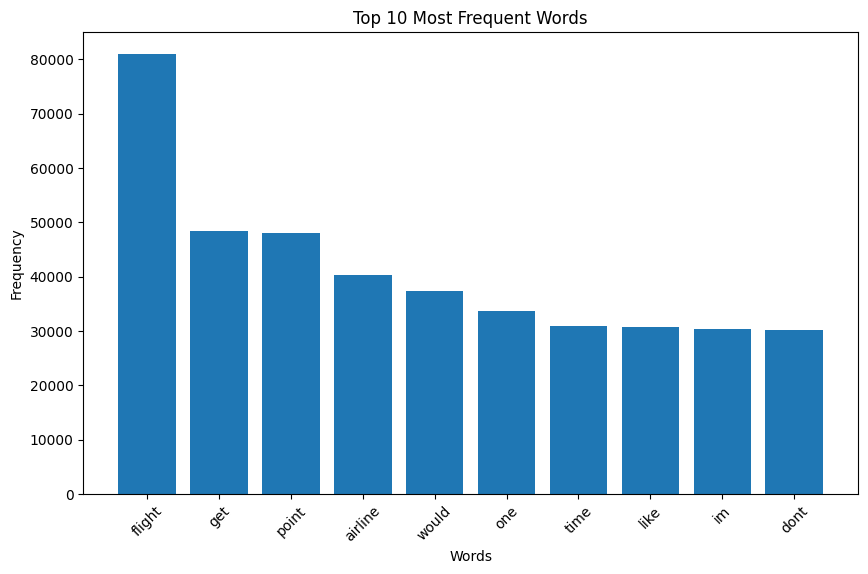

In [ ]:

# Get the most common words and their counts
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words')
plt.xticks(rotation=45)
# Saving the plot
plt.savefig(fname=f"{output_dir}/top10_word_freq.png")
plt.show()

N-GRAM analysis

In [ ]:
# Function to generate n-grams
def generate_ngrams(tokens, n=3):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

# Generate bigrams
df_final['bigrams'] = df_final['tokens'].apply(lambda x: generate_ngrams(x, 3))

# Count bigram frequencies
bigram_counts = Counter()
df_final['bigrams'].apply(bigram_counts.update)

# Display the most common bigrams
print(bigram_counts.most_common(10))

[('if you have', 8219), ('if you are', 6415), ('be able to', 5246), ('please contact the', 5133), ('you have any', 4988), ('i am a', 4690), ('a lot of', 4619), ('have any questions', 4392), ('am a bot', 4370), ('a bot and', 4349)]


In [ ]:
# Total number of unique words
total_unique_words = len(word_counts)

# Average frequency of words
average_frequency = sum(word_counts.values()) / total_unique_words

print(f"Total Unique Words: {total_unique_words}")
print(f"Average Word Frequency: {average_frequency:.2f}")

Total Unique Words: 88907
Average Word Frequency: 62.98


In [ ]:
# Total number of unique n-grams
total_unique_ngrams = len(bigram_counts)

# Average frequency of n-grams
average_ngram_frequency = sum(bigram_counts.values()) / total_unique_ngrams

print(f"Total Unique N-Grams: {total_unique_ngrams}")
print(f"Average N-Gram Frequency: {average_ngram_frequency:.2f}")
df_final.head(5)

Total Unique N-Grams: 4876923
Average N-Gram Frequency: 2.05


,body,created_utc,controversiality,tokens,stopwords,lemma,cleaned_text,bigrams
0,the april flights were booked in aprilmay yo...,1672642725,0,"[the, april, flights, were, booked, in, aprilm...","[april, flights, booked, aprilmay, youre, goin...","[april, flight, booked, aprilmay, youre, going...",april flight booked aprilmay youre going need ...,"[the april flights, april flights were, flight..."
1,wow thanks harsh reality check but that explai...,1672642538,0,"[wow, thanks, harsh, reality, check, but, that...","[wow, thanks, harsh, reality, check, explains,...","[wow, thanks, harsh, reality, check, explains,...",wow thanks harsh reality check explains cant f...,"[wow thanks harsh, thanks harsh reality, harsh..."
2,if you are asking for help finding flights or ...,1672642243,0,"[if, you, are, asking, for, help, finding, fli...","[asking, help, finding, flights, hotel, rooms,...","[asking, help, finding, flight, hotel, room, p...",asking help finding flight hotel room please e...,"[if you are, you are asking, are asking for, a..."
3,transfer to hyatt also read the sidebar,1672642039,0,"[transfer, to, hyatt, also, read, the, sidebar]","[transfer, hyatt, also, read, sidebar]","[transfer, hyatt, also, read, sidebar]",transfer hyatt also read sidebar,"[transfer to hyatt, to hyatt also, hyatt also ..."
4,lol whelp hopefully your plans are flexible an...,1672641432,0,"[lol, whelp, hopefully, your, plans, are, flex...","[lol, whelp, hopefully, plans, flexible, find,...","[lol, whelp, hopefully, plan, flexible, find, ...",lol whelp hopefully plan flexible find availab...,"[lol whelp hopefully, whelp hopefully your, ho..."


BAG OF WORDS
is a baseline model for more complex NLP tasks

In [ ]:
# Download the averaged_perceptron_tagger resource for POS tagging
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
##part of speech

In [ ]:
df_final['tagged']=nltk.pos_tag(df_final['cleaned_text'])

In [ ]:
df_final['tagged']

,tagged
0,(april flight booked aprilmay youre going need...
1,(wow thanks harsh reality check explains cant ...
2,(asking help finding flight hotel room please ...
3,"(transfer hyatt also read sidebar, NN)"
4,(lol whelp hopefully plan flexible find availa...
...,...
83140,(return cancelled show checked bag go c pricin...
83141,"(got private must price published, VBD)"
83142,(wouldnt first choice youre flexible even thou...
83143,(think traveling japan even month main olympic...


In [ ]:
## VADER SENTIMENT SCORING
## we will use sentimentIntensityAnalyzer to get neg/neu/pos scores of the text
## BAG OF WORDS approach
## 1. stop words are removed
## 2. each word is scored and combined to a total score
## QUESTION, WHAT MATH EQUETION IS USED BEHINE?
## NOTE: THIS method does not account for relationships between words. (IT IS VERY IMPORTANT TO US BUT THIS METHOD
## IS GOOD FOR START)S

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('I wish things would have ended better but in a way it is nice that this story ended')

{'neg': 0.0, 'neu': 0.634, 'pos': 0.366, 'compound': 0.7579}

In [ ]:
# Assuming df_final is your DataFrame and 'cleaned_text' is the column with the text
sentiment_score = sia.polarity_scores(df_final['cleaned_text'].iloc[0])

In [ ]:
print(sentiment_score)
print(df_final['cleaned_text'].iloc[0])

{'neg': 0.071, 'neu': 0.737, 'pos': 0.193, 'compound': 0.8316}
april flight booked aprilmay youre going need flexible start planning get lucky people cancel arent people waitlist getting seat also getting difficult ana member get first dibs higher status ana member view additional award space big status match period month ago finally virgin joining skyteam possible awesome ana redemption star alliance longer available


Run the polarity score on the entire dataset

In [ ]:
res={}
for i,row in tqdm(df_final.iterrows()):
        text = row['cleaned_text']
        myid = row['created_utc']
        res[myid]=sia.polarity_scores(text)

0it [00:00, ?it/s]

In [ ]:
vaders=pd.DataFrame(res).T

In [ ]:
df_final.head()
# Saving the df_final
df_final.to_csv(f'{output_dir}/df_final.csv',index = False)

In [ ]:
## THIS VADER MODEL WILL NOT PICK UP THE CONTEXT ON THE WORDS SO WE ARE USING THE TRANSFORMER MODELS

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
df_final.head(5)

,body,created_utc,controversiality,tokens,stopwords,lemma,cleaned_text,bigrams,tagged
0,the april flights were booked in aprilmay yo...,1672642725,0,"[the, april, flights, were, booked, in, aprilm...","[april, flights, booked, aprilmay, youre, goin...","[april, flight, booked, aprilmay, youre, going...",april flight booked aprilmay youre going need ...,"[the april flights, april flights were, flight...",(april flight booked aprilmay youre going need...
1,wow thanks harsh reality check but that explai...,1672642538,0,"[wow, thanks, harsh, reality, check, but, that...","[wow, thanks, harsh, reality, check, explains,...","[wow, thanks, harsh, reality, check, explains,...",wow thanks harsh reality check explains cant f...,"[wow thanks harsh, thanks harsh reality, harsh...",(wow thanks harsh reality check explains cant ...
2,if you are asking for help finding flights or ...,1672642243,0,"[if, you, are, asking, for, help, finding, fli...","[asking, help, finding, flights, hotel, rooms,...","[asking, help, finding, flight, hotel, room, p...",asking help finding flight hotel room please e...,"[if you are, you are asking, are asking for, a...",(asking help finding flight hotel room please ...
3,transfer to hyatt also read the sidebar,1672642039,0,"[transfer, to, hyatt, also, read, the, sidebar]","[transfer, hyatt, also, read, sidebar]","[transfer, hyatt, also, read, sidebar]",transfer hyatt also read sidebar,"[transfer to hyatt, to hyatt also, hyatt also ...","(transfer hyatt also read sidebar, NN)"
4,lol whelp hopefully your plans are flexible an...,1672641432,0,"[lol, whelp, hopefully, your, plans, are, flex...","[lol, whelp, hopefully, plans, flexible, find,...","[lol, whelp, hopefully, plan, flexible, find, ...",lol whelp hopefully plan flexible find availab...,"[lol whelp hopefully, whelp hopefully your, ho...",(lol whelp hopefully plan flexible find availa...


Summary Statistics of Text Lengths:
count    281640.000000
mean         19.885908
std          23.849818
min           1.000000
25%           6.000000
50%          13.000000
75%          26.000000
max         765.000000
Name: text_length, dtype: float64


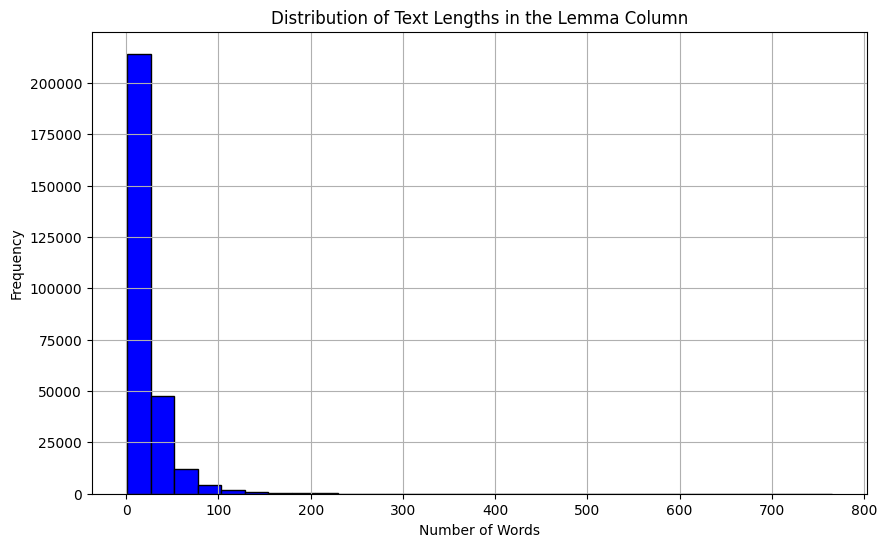

Outliers based on Text Lengths:
    created_utc                                              lemma  \
15   1672637576  [dont, see, saver, available, class, service, ...   
22   1672635794  [amount, award, flight, airline, allocate, sea...   
102  1672613375  [service, good, right, need, change, flight, s...   
113  1672612002  [legit, get, behind, post, flew, air, canada, ...   
127  1672607091  [really, system, designed, weed, thing, consid...   

     text_length  
15            67  
22            80  
102           75  
113           74  
127           85  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_final is your DataFrame and it contains the columns 'created_utc' and 'lemma'

# 1. Calculate text length (number of words) in the 'lemma' column
df_final['text_length'] = df_final['lemma'].apply(lambda x: len(str(x).split()))

# 2. Summary statistics for text lengths
text_length_stats = df_final['text_length'].describe()
print("Summary Statistics of Text Lengths:")
print(text_length_stats)

# 3. Visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df_final['text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths in the Lemma Column')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Identify outliers (extremely short or long texts)
# Here, we'll consider outliers as texts shorter than the 5th percentile or longer than the 95th percentile
lower_bound = df_final['text_length'].quantile(0.05)
upper_bound = df_final['text_length'].quantile(0.95)

outliers = df_final[(df_final['text_length'] < lower_bound) | (df_final['text_length'] > upper_bound)]

# Displaying outliers
print("Outliers based on Text Lengths:")
print(outliers[['created_utc', 'lemma', 'text_length']].head())


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from transformers import RobertaTokenizer
import pandas as pd

# Assuming df_final is your DataFrame and it has a column named 'cleaned_text'
# Initialize the RoBERTa tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = tokenizer
# Define a function to tokenize a single example
def tokenize_function(example):
    return tokenizer(example, padding="max_length", truncation=True)

# Apply the tokenize function to each row in the cleaned_text column
# The result will be a new DataFrame where each row contains the tokenized information of the corresponding text
tokenized_data = pd.DataFrame(df_final['cleaned_text'].apply(lambda x: tokenize_function(x)).tolist())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Assuming tokenized_data is a DataFrame with new columns to add to df_final
# for column in tokenized_data.columns:
    # df_final[column] = tokenized_data[column]

In [ ]:
tokenized_data.head(5)

,attention_mask,input_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1115, 20447, 2524, 7512, 28200, 718, 12488..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 34798, 2446, 9776, 2015, 1649, 4529, 17672..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 30954, 244, 2609, 2524, 2303, 929, 2540, 1..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 40095, 14791, 2611, 67, 1166, 44718, 2, 1,..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 46078, 33116, 39031, 5952, 563, 9538, 465,..."


In [ ]:
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
import torch
from scipy.special import softmax
import numpy as np

def polarity_scores_roberta(text):
    # Tokenize the text and move tensors to CUDA if available
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

    # Ensure the model is on the same device as the inputs
    model.to('cuda')

    with torch.no_grad():
        outputs = model(**inputs)

    scores = outputs.logits.detach().cpu().numpy()  # Move logits to CPU for numpy conversion
    scores = softmax(scores, axis=1)[0]

    # Return the scores in a dictionary format
    return {'roberta_neg': scores[0], 'roberta_neu': scores[1], 'roberta_pos': scores[2]}


In [ ]:
res = {}
for i, row in tqdm(df_final.iterrows(), total=len(df_final)):
    try:
        text = row['cleaned_text']
        myid = row['created_utc']
        # Assuming polarity_scores_roberta function exists and is defined to work with RoBERTa
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
      print(f'broke for myid {myid}')
# Saving the dictionary
#import json
#with open(f"{output_dir}/res.json","w") as file:
 # json.dump(res,file,indent = 4)

  0%|          | 0/281640 [00:00<?, ?it/s]

In [ ]:
# Define a custom JSON encoder function
def custom_encoder(obj):
    if isinstance(obj, np.float32):
        return float(obj)  # Convert np.float32 to regular float
    else:
        raise TypeError(f"Object of type {type(obj)} is not JSON serializable")
        # Saving the dictionary to a JSON file using custom encoder
output_file = f"{output_dir}/res.json"
with open(output_file, "w") as file:
    json.dump(res, file, default=custom_encoder, indent=4)

In [ ]:
#import json
#ts = "2024-04-06_21-19"
#with open(f'/content/drive/My Drive/Colab Notebooks/output/{ts}/res.json',"r") as file:
#with open(f"{output_dir}/res.json","r") as file:
  #res = json.load(file)

In [ ]:

ts = '2024-04-06_21-19'
with open(f"/content/drive/My Drive/Colab Notebooks/output/{ts}/res.json", "r") as file:
    res = json.load(file)

In [ ]:
df_test = pd.DataFrame(list(res.items()),columns=['created_utc','scores'])
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')
df_test.set_index('date', inplace=True)
df_test['roberta_pos'] = df_test['scores'].apply(lambda x: x['roberta_pos'])

<ipython-input-58-820d678e06c6>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


In [ ]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Now, when you call df_test.head(), it should show all columns and the full text in each cell
print(df_test.head())

                    created_utc  \
date                              
2023-01-02 06:58:08  1672642725   
2023-01-02 06:56:00  1672642538   
2023-01-02 06:51:44  1672642243   
2023-01-02 06:47:28  1672642039   
2023-01-02 06:36:48  1672641432   

                                                                                                                           scores  \
date                                                                                                                                
2023-01-02 06:58:08  {'roberta_neg': 0.051934558898210526, 'roberta_neu': 0.47823044657707214, 'roberta_pos': 0.4698348939418793}   
2023-01-02 06:56:00  {'roberta_neg': 0.32964158058166504, 'roberta_neu': 0.46428778767585754, 'roberta_pos': 0.20607060194015503}   
2023-01-02 06:51:44    {'roberta_neg': 0.3734520375728607, 'roberta_neu': 0.5699347257614136, 'roberta_pos': 0.05661319941282272}   
2023-01-02 06:47:28   {'roberta_neg': 0.05594610050320625, 'roberta_neu': 0.8751330375671

In [ ]:
df_test.shape[0]

276553

In [ ]:
##import pandas as pd

df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Define your offset values here
offsets = {
    'high pos': 0.015,
    'high neu': 0,
    'high neg': -0.015,
    'ambiguous pos': 0.015,
    'ambiguous neu': 0,
    'ambiguous neg': -0.015,
    'mild pos': 0.015,
    'mild neu': 0,
    'mild neg': -0.015,
    # Add more if you have other labels
}

def get_advanced_label(row):
    scores = row['scores']

    # Sorting the scores to get the highest and second highest
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    highest = sorted_scores[0]
    second_highest = sorted_scores[1]

    # Extracting label and score
    highest_label, highest_score = highest
    second_highest_label, second_highest_score = second_highest

    # Calculate the difference between the highest and second highest scores
    difference = highest_score - second_highest_score

    # Define thresholds
    high_threshold = 0.75
    mild_threshold = 0.35
    diff_threshold = 0.15  # Threshold for significant difference

    # Simplify label
    base_label = highest_label.split('_')[1]  # e.g., 'neg' from 'roberta_neg'

    # Categorization logic
    if highest_score > high_threshold:
        if difference > diff_threshold:
            label = 'high ' + base_label
        else:
            label = 'ambiguous ' + base_label
    elif highest_score > mild_threshold:
        if difference > diff_threshold:
            label = 'mild ' + base_label
        else:
            label = 'ambiguous ' + base_label
    else:
        label = 'low ' + base_label

    return label, highest_score

# Apply the function to get labels and scores
df_test[['label', 'score']] = df_test.apply(get_advanced_label, axis=1, result_type='expand')

# Apply offsets to create an adjusted score
df_test['adjusted_score'] = df_test.apply(lambda row: row['score'] + offsets.get(row['label'], 0), axis=1)

# Now you can print and see the adjusted scores
print(df_test[['date', 'label', 'score', 'adjusted_score']].head())

<ipython-input-60-0fa76dbc6957>:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


                                   date          label     score  \
date                                                               
2023-01-02 06:58:08 2023-01-02 06:58:08  ambiguous neu  0.478230   
2023-01-02 06:56:00 2023-01-02 06:56:00  ambiguous neu  0.464288   
2023-01-02 06:51:44 2023-01-02 06:51:44       mild neu  0.569935   
2023-01-02 06:47:28 2023-01-02 06:47:28       high neu  0.875133   
2023-01-02 06:36:48 2023-01-02 06:36:48       high pos  0.862796   

                     adjusted_score  
date                                 
2023-01-02 06:58:08        0.478230  
2023-01-02 06:56:00        0.464288  
2023-01-02 06:51:44        0.569935  
2023-01-02 06:47:28        0.875133  
2023-01-02 06:36:48        0.877796  


In [ ]:
df_test.shape[0 ]

276553

<ipython-input-61-7dbc87119b92>:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


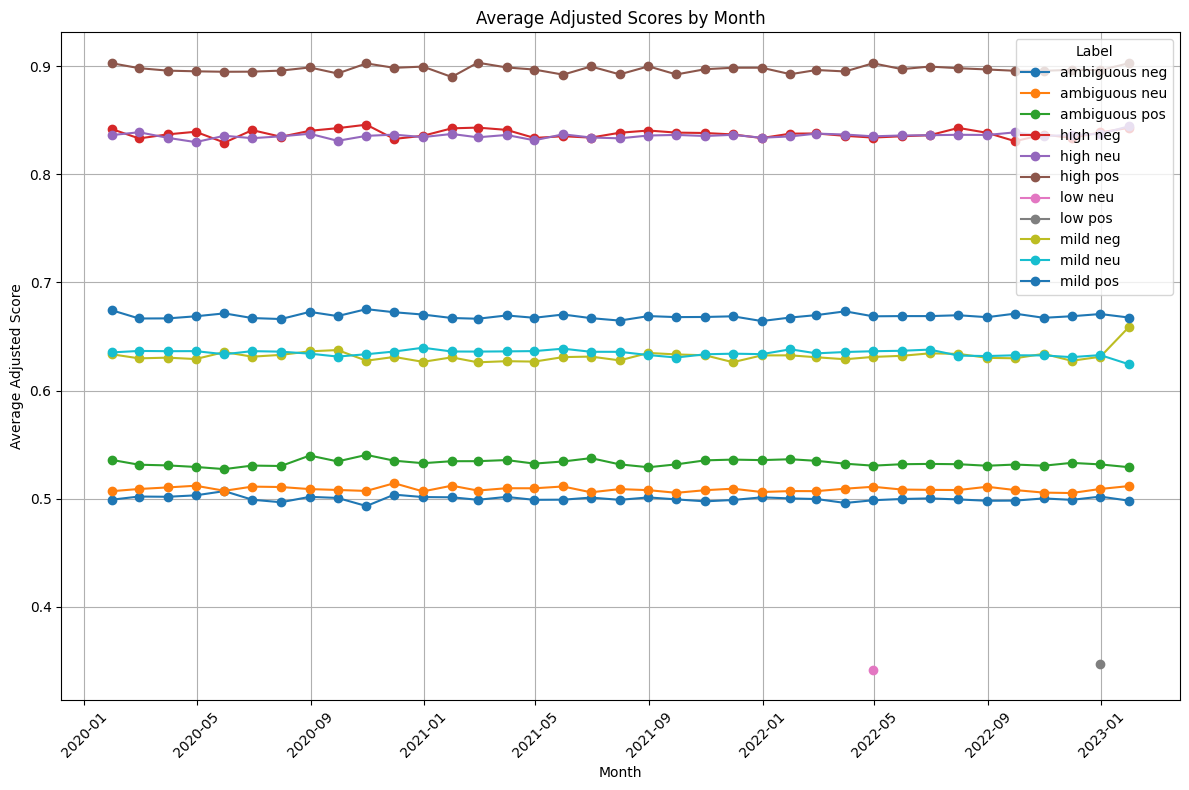

In [ ]:
##import matplotlib.pyplot as plt
##import pandas as pd

# Convert 'created_utc' to datetime and ensure it's in a column named 'date'
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Set 'date' as the index temporarily for resampling
df_test.set_index('date', inplace=True)

# Resample and average the data by month for each label
monthly_scores = df_test.groupby('label').resample('M')['adjusted_score'].mean()

# This creates a MultiIndex, which we need to reset for easier plotting
monthly_scores = monthly_scores.reset_index()

# Remove 'date' from the index to avoid any future ambiguity
df_test.reset_index(inplace=True)

# Get unique labels
unique_labels = monthly_scores['label'].unique()

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot each label as a separate line
for label in unique_labels:
    subset = monthly_scores[monthly_scores['label'] == label]
    plt.plot(subset['date'], subset['adjusted_score'], marker='o', linestyle='-', label=label)

# Add title and labels
plt.title('Average Adjusted Scores by Month')
plt.xlabel('Month')
plt.ylabel('Average Adjusted Score')
plt.legend(title='Label')  # Add a legend to distinguish the lines

# Add grid and rotate x-axis labels for better readability
plt.grid(True)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

# Group by month and label, then calculate statistics
monthly_stats = df_test.groupby([pd.Grouper(freq='M'), 'label']).agg(
    mean_score=('score', 'mean'),
    std_deviation=('score', 'std'),
    count=('score', 'count')
)

# Calculate standard error of the means
monthly_stats['sem_score'] = monthly_stats['std_deviation'] / np.sqrt(monthly_stats['count'])

# Repeat for adjusted_score
monthly_stats['mean_adjusted_score'] = df_test.groupby([pd.Grouper(freq='M'), 'label'])['adjusted_score'].mean()
monthly_stats['std_deviation_adjusted'] = df_test.groupby([pd.Grouper(freq='M'), 'label'])['adjusted_score'].std()
monthly_stats['sem_adjusted_score'] = monthly_stats['std_deviation_adjusted'] / np.sqrt(monthly_stats['count'])

print(monthly_stats)

                          mean_score  std_deviation  count  sem_score  \
date       label                                                        
2020-01-31 ambiguous neg    0.514119       0.027588    263   0.001701   
           ambiguous neu    0.506949       0.035245    600   0.001439   
           ambiguous pos    0.520792       0.029403    237   0.001910   
           high neg         0.856681       0.063393    284   0.003762   
           high neu         0.836239       0.049244   2154   0.001061   
           high pos         0.887602       0.068553    960   0.002213   
           mild neg         0.648478       0.053580    420   0.002614   
           mild neu         0.635259       0.065458   2593   0.001285   
           mild pos         0.659142       0.055907    460   0.002607   
2020-02-29 ambiguous neg    0.516975       0.026003    283   0.001546   
           ambiguous neu    0.508966       0.033523    587   0.001384   
           ambiguous pos    0.516409       0.030871

In [ ]:
# Group by month only and calculate statistics
monthly_stats = df_test.groupby(pd.Grouper(freq='M')).agg(
    mean_score=('score', 'mean'),
    std_deviation=('score', 'std'),
    count=('score', 'count')
)
monthly_stats['sem_score'] = monthly_stats['std_deviation'] / np.sqrt(monthly_stats['count'])

# Reset the index to turn 'date' back into a column for easier access and manipulation
monthly_stats = monthly_stats.reset_index()[['date', 'mean_score', 'std_deviation', 'count', 'sem_score']]

print(monthly_stats)


         date  mean_score  std_deviation  count  sem_score
0  2020-01-31    0.712866       0.140347   7971   0.001572
1  2020-02-29    0.710957       0.138172   8338   0.001513
2  2020-03-31    0.700397       0.133623   7409   0.001552
3  2020-04-30    0.695279       0.133009   5010   0.001879
4  2020-05-31    0.696575       0.133929   4477   0.002002
5  2020-06-30    0.698339       0.136311   4749   0.001978
6  2020-07-31    0.700176       0.134342   4119   0.002093
7  2020-08-31    0.704916       0.136148   3817   0.002204
8  2020-09-30    0.696403       0.136190   3588   0.002274
9  2020-10-31    0.712364       0.138800   4113   0.002164
10 2020-11-30    0.706263       0.134026   3653   0.002218
11 2020-12-31    0.708725       0.137532   4946   0.001956
12 2021-01-31    0.701748       0.135485   4982   0.001920
13 2021-02-28    0.703794       0.135675   4544   0.002013
14 2021-03-31    0.709572       0.136834   6102   0.001752
15 2021-04-30    0.703669       0.134090   6545   0.0016

<ipython-input-64-31fd7567c663>:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


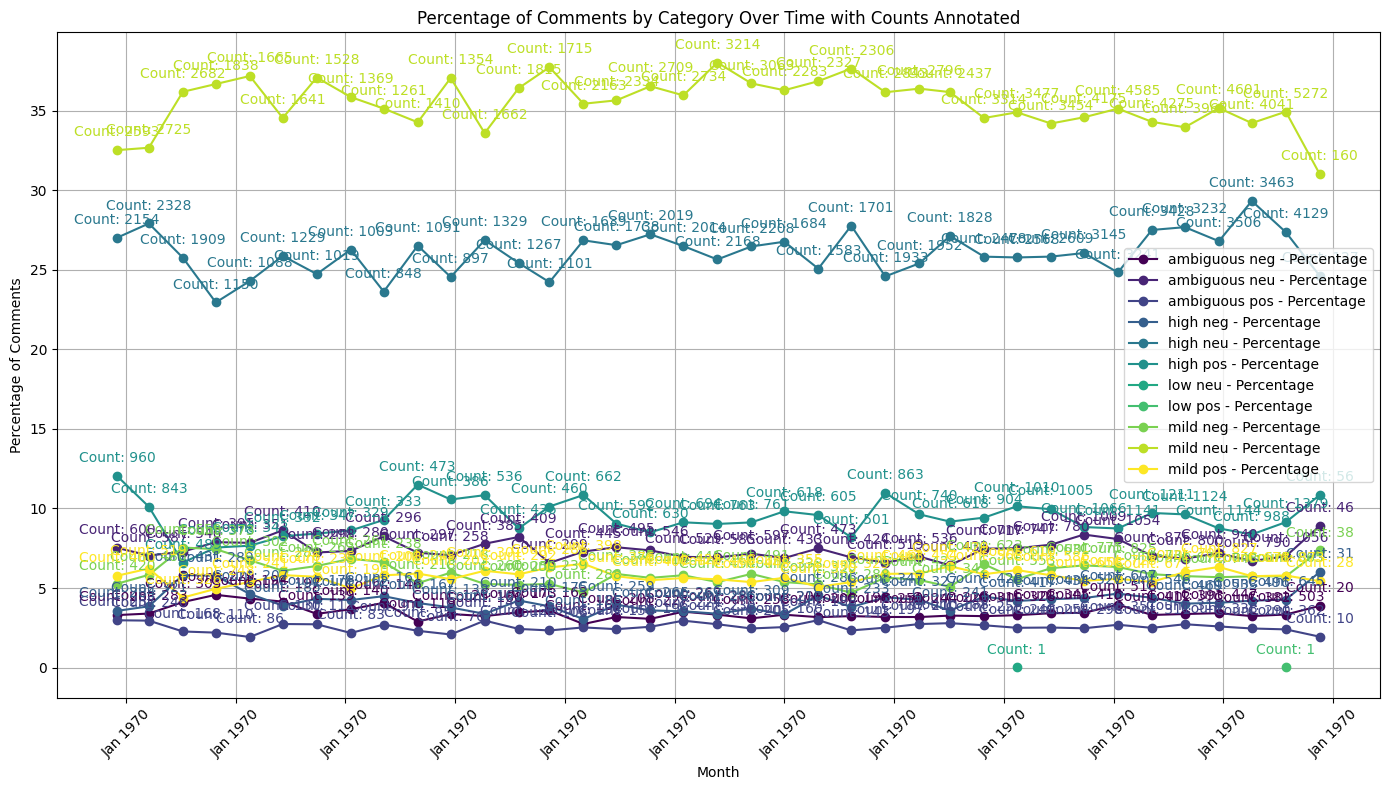

In [ ]:
##import matplotlib.pyplot as plt
##import pandas as pd
##import numpy as np

# Convert 'created_utc' to datetime and ensure it's in a column named 'date'
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Set 'date' as the index temporarily for resampling
df_test.set_index('date', inplace=True)

# Resample and average the data by month for each label
monthly_scores = df_test.groupby('label').resample('M')['adjusted_score'].mean().reset_index()
monthly_counts = df_test.groupby('label').resample('M').size().reset_index(name='counts')

# Resample to get total counts by month
total_monthly_counts = df_test.resample('M').size().reset_index(name='total_counts')

# Merge monthly counts with total counts to align dates correctly
monthly_counts = pd.merge(monthly_counts, total_monthly_counts, on='date', how='left')

# Calculate percentages
monthly_counts['percentage'] = monthly_counts['counts'] / monthly_counts['total_counts'] * 100

# Separate the data by label for plotting
data_by_label = {label: monthly_counts[monthly_counts['label'] == label] for label in monthly_counts['label'].unique()}

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting data
colors = plt.cm.viridis(np.linspace(0, 1, len(data_by_label)))
for (label, data), color in zip(data_by_label.items(), colors):
    ax.plot(data['date'], data['percentage'], label=f'{label} - Percentage', marker='o', linestyle='-', color=color)
    # Annotate each point with the count
    for (x, y, text) in zip(data['date'], data['percentage'], data['counts']):
        ax.annotate(f'Count: {text}', xy=(x, y), textcoords="offset points", xytext=(0,10), ha='center', color=color)

# Format the x-axis with month names
ax.xaxis.set_major_locator(plt.MaxNLocator(15))  # Adjust locator depending on date range
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: pd.to_datetime(x).strftime('%b %Y')))

# Set titles and labels
plt.title('Percentage of Comments by Category Over Time with Counts Annotated')
plt.xlabel('Month')
plt.ylabel('Percentage of Comments')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-65-35d9394a7169>:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


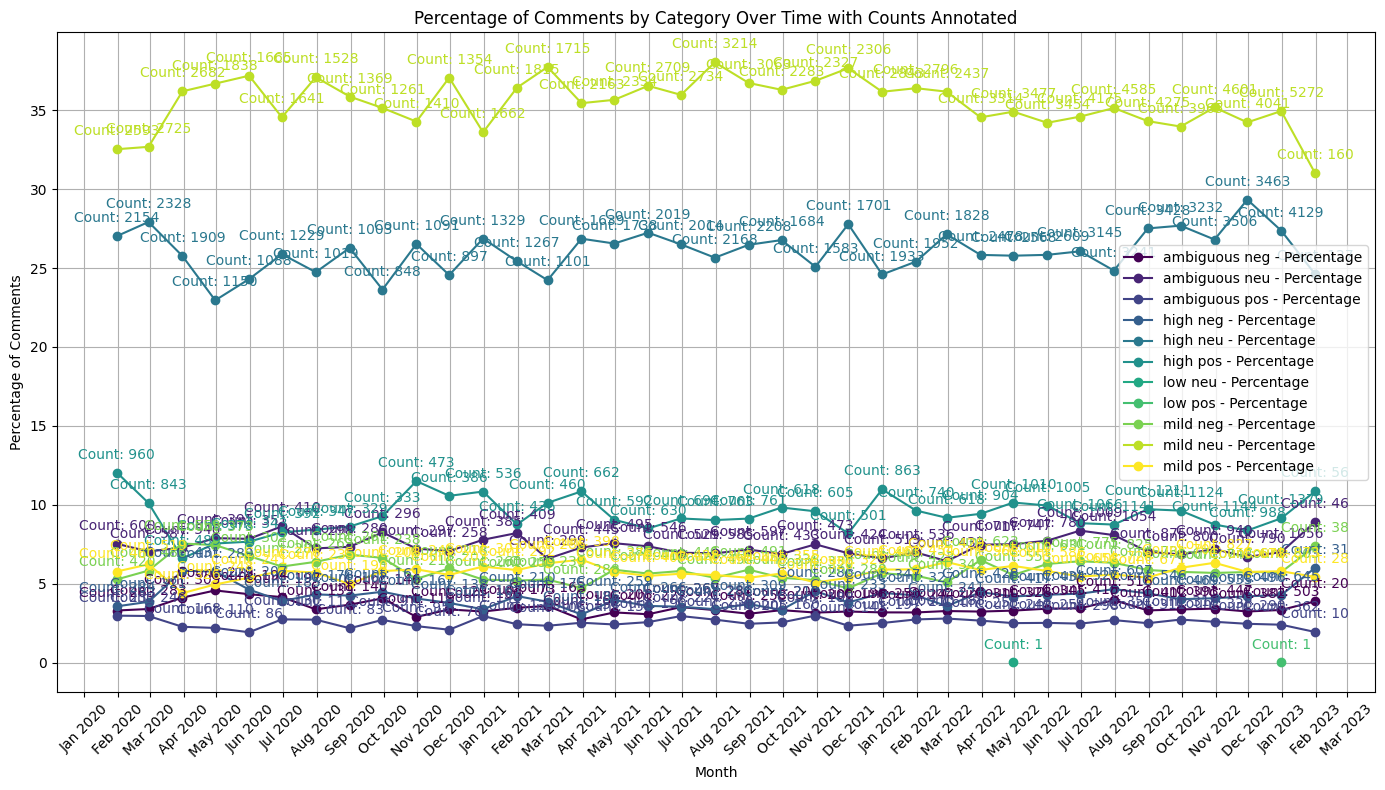

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Convert 'created_utc' to datetime and ensure it's in a column named 'date'
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Set 'date' as the index temporarily for resampling
df_test.set_index('date', inplace=True)

# Resample and average the data by month for each label
monthly_scores = df_test.groupby('label').resample('M')['adjusted_score'].mean().reset_index()
monthly_counts = df_test.groupby('label').resample('M').size().reset_index(name='counts')

# Resample to get total counts by month
total_monthly_counts = df_test.resample('M').size().reset_index(name='total_counts')

# Merge monthly counts with total counts to align dates correctly
monthly_counts = pd.merge(monthly_counts, total_monthly_counts, on='date', how='left')

# Calculate percentages
monthly_counts['percentage'] = monthly_counts['counts'] / monthly_counts['total_counts'] * 100

# Make sure 'date' is a datetime type after merging
monthly_counts['date'] = pd.to_datetime(monthly_counts['date'])

# Separate the data by label for plotting
data_by_label = {label: monthly_counts[monthly_counts['label'] == label] for label in monthly_counts['label'].unique()}

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting data
colors = plt.cm.viridis(np.linspace(0, 1, len(data_by_label)))
for (label, data), color in zip(data_by_label.items(), colors):
    ax.plot(data['date'], data['percentage'], label=f'{label} - Percentage', marker='o', linestyle='-', color=color)
    # Annotate each point with the count
    for (x, y, text) in zip(data['date'], data['percentage'], data['counts']):
        ax.annotate(f'Count: {text}', xy=(x, y), textcoords="offset points", xytext=(0,10), ha='center', color=color)

# Format the x-axis with month names and ensure it handles datetime objects properly
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set titles and labels
plt.title('Percentage of Comments by Category Over Time with Counts Annotated')
plt.xlabel('Month')
plt.ylabel('Percentage of Comments')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-66-b4a73e8dd78f>:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


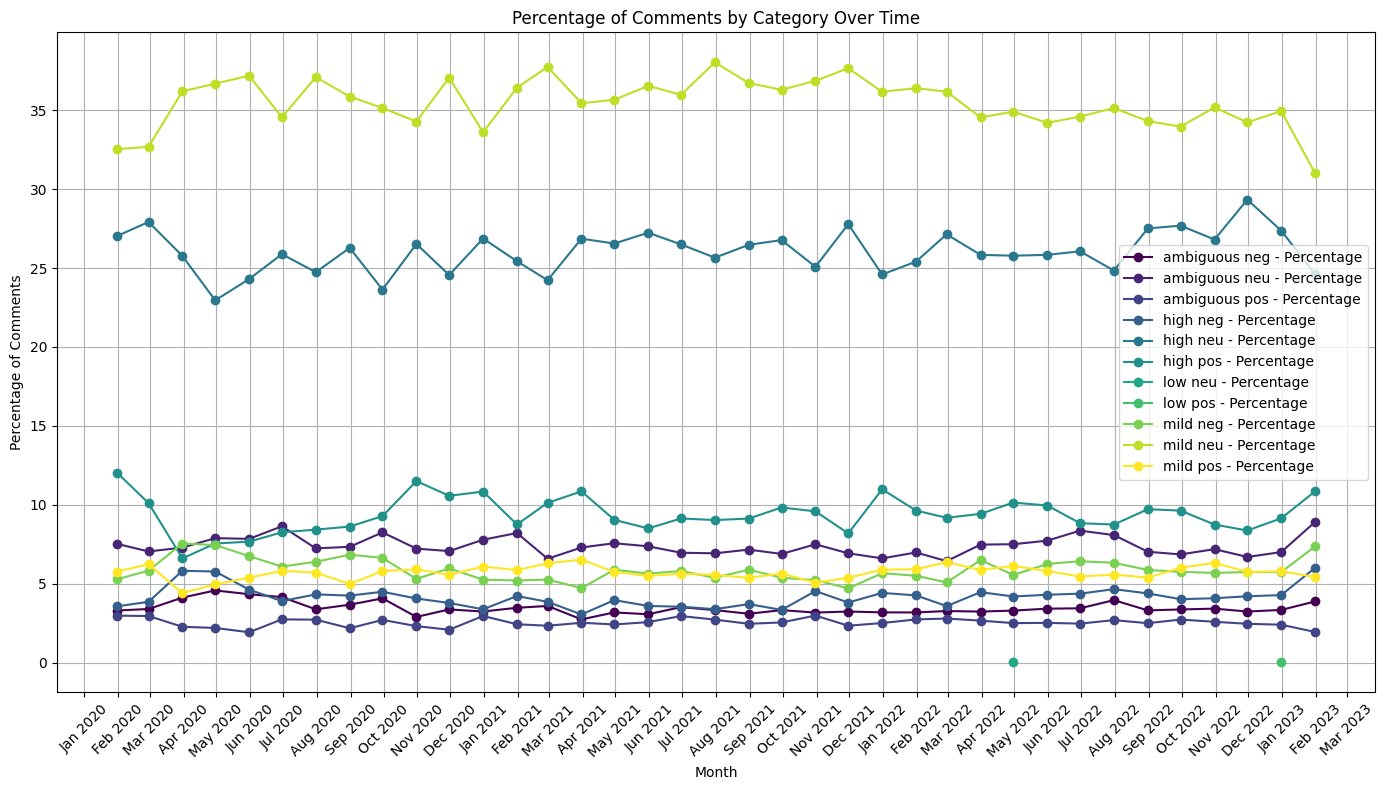

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Convert 'created_utc' to datetime and ensure it's in a column named 'date'
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Set 'date' as the index temporarily for resampling
df_test.set_index('date', inplace=True)

# Resample and average the data by month for each label
monthly_scores = df_test.groupby('label').resample('M')['adjusted_score'].mean().reset_index()
monthly_counts = df_test.groupby('label').resample('M').size().reset_index(name='counts')

# Resample to get total counts by month
total_monthly_counts = df_test.resample('M').size().reset_index(name='total_counts')

# Merge monthly counts with total counts to align dates correctly
monthly_counts = pd.merge(monthly_counts, total_monthly_counts, on='date', how='left')

# Calculate percentages
monthly_counts['percentage'] = monthly_counts['counts'] / monthly_counts['total_counts'] * 100

# Make sure 'date' is a datetime type after merging
monthly_counts['date'] = pd.to_datetime(monthly_counts['date'])

# Separate the data by label for plotting
data_by_label = {label: monthly_counts[monthly_counts['label'] == label] for label in monthly_counts['label'].unique()}

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting data
colors = plt.cm.viridis(np.linspace(0, 1, len(data_by_label)))
for (label, data), color in zip(data_by_label.items(), colors):
    ax.plot(data['date'], data['percentage'], label=f'{label} - Percentage', marker='o', linestyle='-', color=color)

# Format the x-axis with month names and ensure it handles datetime objects properly
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set titles and labels
plt.title('Percentage of Comments by Category Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage of Comments')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-125-77cb2dba0a8d>:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')


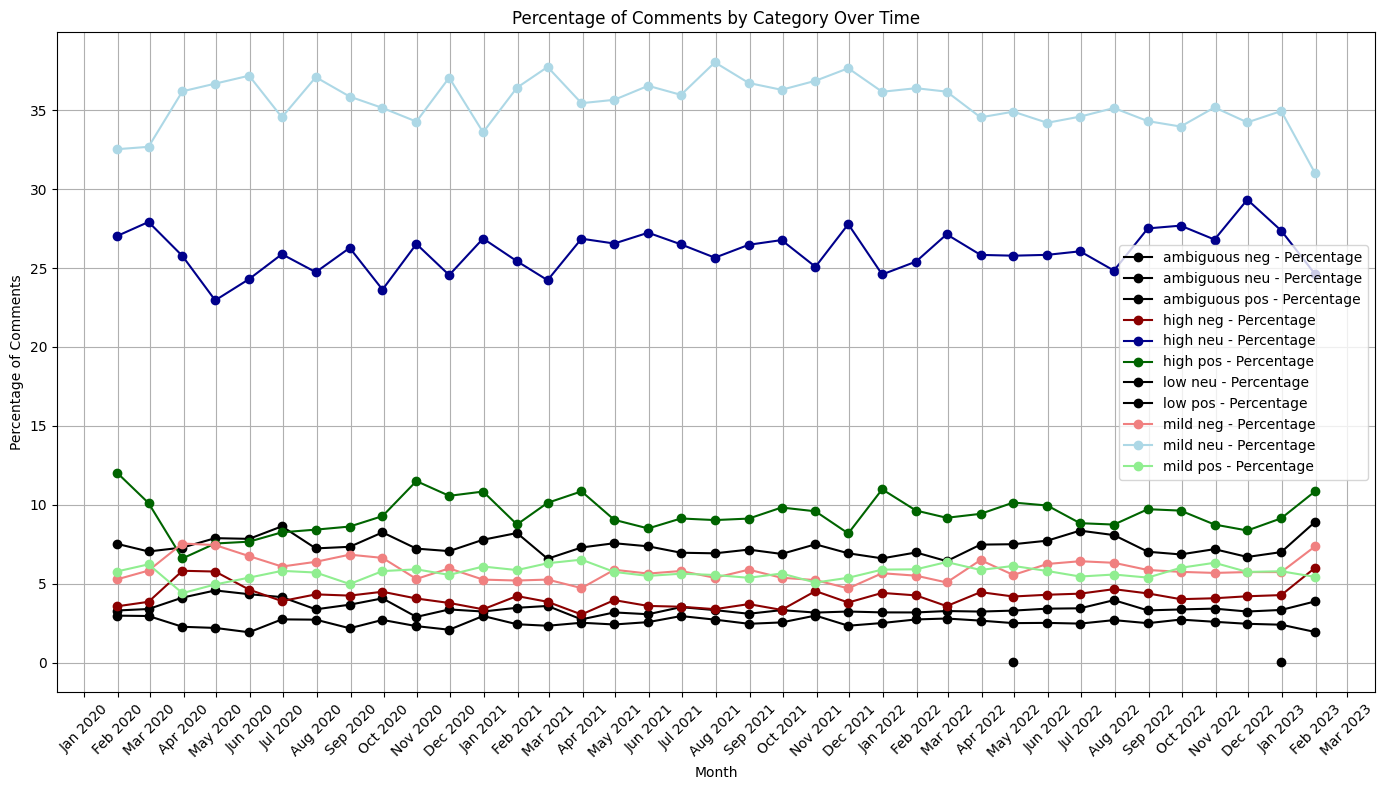

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Convert 'created_utc' to datetime and ensure it's in a column named 'date'
df_test['date'] = pd.to_datetime(df_test['created_utc'], unit='s')

# Set 'date' as the index temporarily for resampling
df_test.set_index('date', inplace=True)

# Resample and average the data by month for each label
monthly_scores = df_test.groupby('label').resample('M')['adjusted_score'].mean().reset_index()
monthly_counts = df_test.groupby('label').resample('M').size().reset_index(name='counts')

# Resample to get total counts by month
total_monthly_counts = df_test.resample('M').size().reset_index(name='total_counts')

# Merge monthly counts with total counts to align dates correctly
monthly_counts = pd.merge(monthly_counts, total_monthly_counts, on='date', how='left')

# Calculate percentages
monthly_counts['percentage'] = monthly_counts['counts'] / monthly_counts['total_counts'] * 100

# Make sure 'date' is a datetime type after merging
monthly_counts['date'] = pd.to_datetime(monthly_counts['date'])

# Separate the data by label for plotting
data_by_label = {label: monthly_counts[monthly_counts['label'] == label] for label in monthly_counts['label'].unique()}

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Define specific colors for each label based on your dataset's actual labels
color_mapping = {
    'high pos': 'darkgreen',
    'high neg': 'darkred',
    'high neu': 'darkblue',
    'mild pos': 'lightgreen',
    'mild neg': 'lightcoral',
    'mild neu': 'lightblue'
}
# Plotting data with specified colors
for label, data in data_by_label.items():
    ax.plot(data['date'], data['percentage'], label=f'{label} - Percentage', marker='o', linestyle='-', color=color_mapping.get(label, 'black'))

# Format the x-axis with month names and ensure it handles datetime objects properly
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set titles and labels
plt.title('Percentage of Comments by Category Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage of Comments')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Define the list of categories you are interested in
categories = ['high pos', 'high neg', 'high neu', 'mild neu', 'mild pos', 'mild neg']

# Filter the DataFrame to include only the rows with labels in the specified categories
filtered_df2 = df_test[df_test['label'].isin(categories)]
filtered_df2 = filtered_df2[['created_utc', 'label', 'score']]
# Print the filtered DataFrame
print(filtered_df2.head())

                    created_utc     label     score
date                                               
2023-01-02 06:51:44  1672642243  mild neu  0.569935
2023-01-02 06:47:28  1672642039  high neu  0.875133
2023-01-02 06:36:48  1672641432  high pos  0.862796
2023-01-02 06:28:16  1672640882  mild neu  0.590709
2023-01-02 06:26:08  1672640760  mild neu  0.604071


In [ ]:
filtered_df2.shape[0]

239787

In [ ]:
is_unique = filtered_df2['created_utc'].is_unique
print("Is the 'created_utc' column unique?", is_unique)

Is the 'created_utc' column unique? True


In [ ]:
is_unique = df_final['created_utc'].is_unique
print("Is the 'created_utc' column unique?", is_unique)

Is the 'created_utc' column unique? False


In [ ]:
## I merge the 2 datasets
merged_df = pd.merge(filtered_df2,df_final,on='created_utc', how='left', suffixes=('', '_y'))
# Selecting specific columns, note how we handle potential column name conflicts
final_df = merged_df[['created_utc', 'label', 'score', 'cleaned_text']]
num_rows = len(final_df)

In [ ]:

# Convert 'created_utc' from UNIX timestamp to 'YYYY-MM-DD'
final_df['created_utc'] = pd.to_datetime(final_df['created_utc'], unit='s').dt.date


<ipython-input-71-08668b70e1f5>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  final_df['created_utc'] = pd.to_datetime(final_df['created_utc'], unit='s').dt.date
<ipython-input-71-08668b70e1f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['created_utc'] = pd.to_datetime(final_df['created_utc'], unit='s').dt.date


In [ ]:
final_df.head()

,created_utc,label,score,cleaned_text
0,2023-01-02,mild neu,0.569935,asking help finding flight hotel room please ensure rule httpwwwredditcomrawardtravelwikirules followed lowquality post may deleted without warning rawardtravel place discus anything related redeeming airline mile amp hotel point bot action performed automatically please contact moderator subredditmessagecomposetorawardtravel question concern
1,2023-01-02,high neu,0.875133,transfer hyatt also read sidebar
2,2023-01-02,high pos,0.862796,lol whelp hopefully plan flexible find availability soon godspeed brotha
3,2023-01-02,mild neu,0.590709,lol thing
4,2023-01-02,mild neu,0.604071,aa limited transfer partner think one major one bilt dont think allow transfer amex chase citi capone


In [ ]:
import pandas as pd
from datetime import datetime

# Define periods to analyze
periods = [
    ('2020-01-01', '2020-05-31'),
    ('2020-10-01', '2021-01-31'),
    ('2021-11-01', '2022-01-31'),
    ('2022-11-01','2023-01-31')
]

# Initialize an empty DataFrame to hold the filtered data
selected_df = pd.DataFrame()

# Convert string dates in periods to datetime.date objects
periods = [(datetime.strptime(start, '%Y-%m-%d').date(), datetime.strptime(end, '%Y-%m-%d').date()) for start, end in periods]

# Filter data for each period and append to selected_df
for start_date, end_date in periods:
    mask = (final_df['created_utc'] >= start_date) & (final_df['created_utc'] <= end_date)
    period_data = final_df.loc[mask]
    selected_df = pd.concat([selected_df, period_data])  # Append to selected_df, not final_df again

# Print the filtered DataFrame
print(selected_df.head())  # Prints only the first few rows of the filtered DataFrame


       created_utc     label     score  \
137142  2020-05-31  mild neu  0.569819   
137143  2020-05-31  mild neu  0.617377   
137144  2020-05-31  mild neu  0.610706   
137145  2020-05-31  mild neu  0.576460   
137146  2020-05-31  mild neu  0.629136   

                                                                                                                                                                        cleaned_text  
137142                                                                                                                                                           ill pay mosaic much  
137143  redemption november right riding shoe would either moving trip availability cancelling letting point sit cash transfer hilton come massive loss november id roll dice rebook  
137144                                                                                                                sure planning hilton redemption soon wouldnt speculatively buy  
137145         

In [ ]:
# Define words to remove
remove_words = {'u', 'k', 'ive', 'im', 'youre','j','f','v','also','get','would','go'}

# Function to remove specified words
def remove_unwanted_words(text):
    # Split text into words
    words = text.split()
    # Filter words to remove the unwanted ones
    filtered_words = [word for word in words if word not in remove_words]
    # Join words back into a single string
    return ' '.join(filtered_words)

# Apply the function to the 'cleaned_text' column
selected_df['cleaned_text'] = selected_df['cleaned_text'].apply(remove_unwanted_words)



In [ ]:
selected_df.head()

,created_utc,label,score,cleaned_text
137142,2020-05-31,mild neu,0.569819,ill pay mosaic much
137143,2020-05-31,mild neu,0.617377,redemption november right riding shoe either moving trip availability cancelling letting point sit cash transfer hilton come massive loss november id roll dice rebook
137144,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt speculatively buy
137145,2020-05-31,mild neu,0.576460,thanks
137146,2020-05-31,mild neu,0.629136,bigger w


In [ ]:
selected_df.shape[0]

87034

In [ ]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'  # Adjust 'your_folder' as needed

# Save DataFrame to CSV in the specified Google Drive folder
selected_df.to_csv(path, index=False)

In [ ]:
import pandas as pd

In [ ]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'  # Adjust 'your_folder' as needed
# Load the DataFrame from the CSV file
df = pd.read_csv(path)
## eixe file_path

In [ ]:
selected_df.shape[0]

87034

[('flight', 23413), ('point', 14079), ('airline', 11877), ('one', 10011), ('time', 8910), ('like', 8827), ('dont', 8350), ('ticket', 7359), ('day', 7284), ('mile', 7153), ('hotel', 6844), ('book', 6802), ('travel', 6695), ('way', 5935), ('award', 5761), ('trip', 5572), ('good', 5523), ('think', 5495), ('see', 5180), ('year', 5157), ('need', 5146), ('back', 5070), ('use', 5025), ('know', 5009), ('may', 4980), ('night', 4950), ('seat', 4936), ('even', 4785), ('thats', 4675), ('booking', 4664), ('going', 4647), ('card', 4632), ('want', 4511), ('much', 4506), ('make', 4503), ('still', 4358), ('deleted', 4315), ('could', 4270), ('thanks', 4221), ('people', 4213), ('sure', 4188), ('united', 4131), ('booked', 4096), ('check', 4088), ('really', 4018), ('first', 4001), ('hour', 3993), ('aa', 3891), ('fly', 3869), ('airport', 3847)]


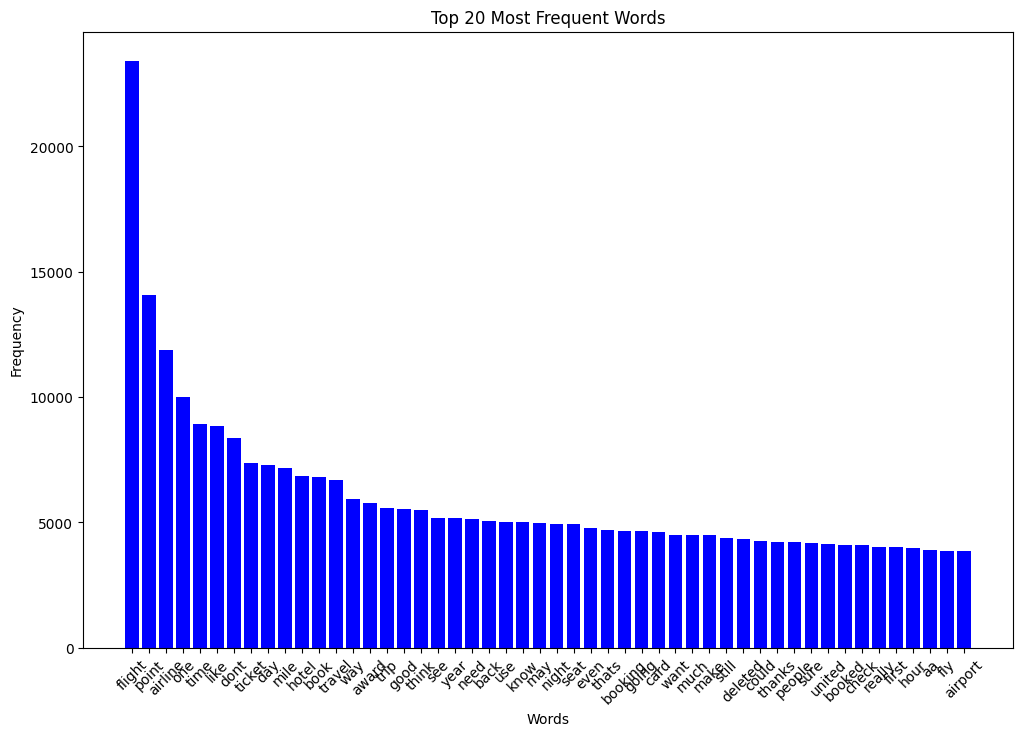

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Count the remaining words directly from the cleaned text
word_counts = Counter()
for line in selected_df['cleaned_text']:
    words = line.split()
    word_counts.update(words)

# Display the most common words
print(word_counts.most_common(50))

# Get the most common words and their counts
top_words = word_counts.most_common(50)
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(words, counts, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# # Filter the DataFrame
# high_pos_df = selected_df[selected_df['label'] == 'high pos']

# # Convert the 'created_utc' column to datetime
# high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# # Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'

# # Filter the DataFrame for entries within the specified date range
# high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# # Print the filtered DataFrame to check the result
# high_pos_df.head()

In [ ]:
# high_pos_df.shape[0]

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')

# # Step 2: Prepare the Text Data
# # Assuming 'final_df' is your DataFrame and it contains a 'cleaned_text' column
# texts = high_pos_df['cleaned_text'].apply(word_tokenize).tolist()

# # Step 3: Create a Gensim Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Step 4: Configure and Run LDA Model
# num_topics = 5  # Set the number of topics, adjust based on your analysis needs
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=25, random_state=42)

# # Step 5: Display the Topics
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Perplexity
# print('Perplexity: ', ldamodel.log_perplexity(corpus))  # Lower the better

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)  # Higher the better

In [ ]:

# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(ldamodel, corpus, dictionary)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)


In [ ]:
# ### HIGH POSITIVE FIRST PERIOD HYPERPARAMETER TUNING
# # supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b,texts):

#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

#     return coherence_model_lda.get_coherence()


In [ ]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,texts=texts,
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)

#                     pbar.update(1)


In [ ]:
# results_df = pd.DataFrame(model_results)
# # Replace 'YourUsername' with your actual username on your macOS machine
# results_df.to_csv('/content/drive/My Drive/Colab Notebooks/lda_tuning_results.csv', index=False)


In [ ]:
# num_topics = 3

# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=num_topics,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=0.3,
#                                            eta='symmetric')

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pickle
# import pyLDAvis

# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('/content/drive/My Drive/Colab Notebooks/ldavis_tuned_'+str(num_topics))

# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, '/content/drive/My Drive/Colab Notebooks/ldavis_tuned_'+ str(num_topics) +'.html')

# LDAvis_prepared

In [ ]:
# # Filter the DataFrame
# high_neg_df = selected_df[selected_df['label'] == 'high neg']

# # Convert the 'created_utc' column to datetime
# high_neg_df['created_utc'] = pd.to_datetime(high_neg_df['created_utc'])

# # Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'

# # Filter the DataFrame for entries within the specified date range
# high_neg_df = high_neg_df[(high_neg_df['created_utc'] >= start_date) & (high_neg_df['created_utc'] <= end_date)]



# # Print the filtered DataFrame to check the result
# high_neg_df.head()

In [ ]:
# high_neg_df.shape[0]

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')

# # Step 2: Prepare the Text Data
# # Assuming 'final_df' is your DataFrame and it contains a 'cleaned_text' column
# texts = high_neg_df['cleaned_text'].apply(word_tokenize).tolist()

# # Step 3: Create a Gensim Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Step 4: Configure and Run LDA Model
# num_topics = 5  # Set the number of topics, adjust based on your analysis needs
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=25, random_state=42)

# # Step 5: Display the Topics
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Perplexity
# print('Perplexity: ', ldamodel.log_perplexity(corpus))  # Lower the better

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)  # Higher the better

In [ ]:

# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(ldamodel, corpus, dictionary)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)


In [ ]:
# ## high negative hyper parameter tuning
# # supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b,texts):

#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

#     return coherence_model_lda.get_coherence()



In [ ]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,texts=texts,
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)

#                     pbar.update(1)


In [ ]:
# results_negative_df = pd.DataFrame(model_results)
# # Replace 'YourUsername' with your actual username on your macOS machine
# results_negative_df.to_csv('/content/drive/My Drive/Colab Notebooks/lda_tuning_results_negative.csv', index=False)

In [ ]:
# num_topics = 2

# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=num_topics,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=0.9,
#                                            eta=0.9)

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pickle
# import pyLDAvis

# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('/content/drive/My Drive/Colab Notebooks/ldavis_tuned_negative'+str(num_topics))

# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, '/content/drive/My Drive/Colab Notebooks/ldavis_tuned_negative'+ str(num_topics) +'.html')

# LDAvis_prepared

In [ ]:
# # Filter the DataFrame
# high_neu_df = selected_df[selected_df['label'] == 'high neu']

# # Convert the 'created_utc' column to datetime
# high_neu_df['created_utc'] = pd.to_datetime(high_neu_df['created_utc'])

# # Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'

# # Filter the DataFrame for entries within the specified date range
# high_neu_df = high_neu_df[(high_neu_df['created_utc'] >= start_date) & (high_neu_df['created_utc'] <= end_date)]


# # Print the filtered DataFrame to check the result
# high_neu_df.head()

In [ ]:
# high_neu_df.shape[0]

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')

# # Step 2: Prepare the Text Data
# # Assuming 'final_df' is your DataFrame and it contains a 'cleaned_text' column
# texts = high_neu_df['cleaned_text'].apply(word_tokenize).tolist()

# # Step 3: Create a Gensim Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Step 4: Configure and Run LDA Model
# num_topics = 5  # Set the number of topics, adjust based on your analysis needs
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=25, random_state=42)

# # Step 5: Display the Topics
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Perplexity
# print('Perplexity: ', ldamodel.log_perplexity(corpus))  # Lower the better

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)  # Higher the better

In [ ]:

# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(ldamodel, corpus, dictionary)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)


In [ ]:
# ## high neutral hyper parameter tuning
# # supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b,texts):

#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

#     return coherence_model_lda.get_coherence()

In [ ]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,texts=texts,
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)

#                     pbar.update(1)


In [ ]:
# results_neutral_df = pd.DataFrame(model_results)
# # Replace 'YourUsername' with your actual username on your macOS machine
# results_neutral_df.to_csv('/content/drive/My Drive/Colab Notebooks/lda_tuning_results_neutral_high.csv', index=False)

In [ ]:
# num_topics = 3

# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=num_topics,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=0.01,
#                                            eta=0.01)

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pickle
# import pyLDAvis

# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('/content/drive/My Drive/Colab Notebooks/ldavis_tuned_neutral_hi'+str(num_topics))

# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, '/content/drive/My Drive/Colab Notebooks/ldavis_tuned_neutral_hi'+ str(num_topics) +'.html')

# LDAvis_prepared

In [ ]:
# # Filter the DataFrame
# mild_neg_df = selected_df[selected_df['label'] == 'mild neg']

# # Convert the 'created_utc' column to datetime
# mild_neg_df['created_utc'] = pd.to_datetime(mild_neg_df['created_utc'])

# # Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'

# # Filter the DataFrame for entries within the specified date range
# mild_neg_df = mild_neg_df[(mild_neg_df['created_utc'] >= start_date) & (mild_neg_df['created_utc'] <= end_date)]


# # Print the filtered DataFrame to check the result
# mild_neg_df.head()

In [ ]:
# mild_neg_df.shape[0]

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')

# # Step 2: Prepare the Text Data
# # Assuming 'final_df' is your DataFrame and it contains a 'cleaned_text' column
# texts = mild_neg_df['cleaned_text'].apply(word_tokenize).tolist()

# # Step 3: Create a Gensim Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Step 4: Configure and Run LDA Model
# num_topics = 5  # Set the number of topics, adjust based on your analysis needs
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=25, random_state=42)

# # Step 5: Display the Topics
# topics = ldamodel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)

In [ ]:

# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(ldamodel, corpus, dictionary)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)


In [ ]:
# from gensim.models import CoherenceModel

# # Compute Perplexity
# print('Perplexity: ', ldamodel.log_perplexity(corpus))  # Lower the better

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)  # Higher the better

In [ ]:
# # supporting function
# def compute_coherence_values(corpus, dictionary,texts, k, a, b):

#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
# #
#     return coherence_model_lda.get_coherence()

In [ ]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, texts=texts,
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)

#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(ldamodel, corpus, dictionary)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)
